Get the complete data_set, together with the train and test data_set

In [1]:
from tf_chpvk_pv.dataset import *
import pandas as pd

df = create_dataset()
train_df, test_df = train_test_split_()

2025-12-09 10:37:14.949 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV


2025-12-09 10:37:15.356 | INFO     | tf_chpvk_pv.dataset:create_dataset:41 - Processing dataset...
2025-12-09 10:37:16.474 | SUCCESS  | tf_chpvk_pv.dataset:create_dataset:213 - Processing dataset complete.
2025-12-09 10:37:16.745 | INFO     | tf_chpvk_pv.dataset:train_test_split_:227 - Creating train and test dataset...
2025-12-09 10:37:16.763 | SUCCESS  | tf_chpvk_pv.dataset:train_test_split_:261 - Creating train and test dataset complete.


In [2]:
#count the number of material in each class in the training/test sets
dict_ch = {133:'F',
        181:'Cl',
        198:'Se',
        196:'Br',
        184.:'S',
        220.00000000000003:'I'
        }

train_df['X'] = train_df.replace({'rX':dict_ch})['rX']
test_df['X'] = test_df.replace({'rX':dict_ch})['rX']

train_vc = pd.DataFrame(train_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())
test_vc = pd.DataFrame(test_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())

print('In the training set, %s compositions are unstable and %s are stable.' % (train_df['exp_label'].value_counts().values[0], train_df['exp_label'].value_counts().values[1]))
print('The distribution in the training set by anions is the following')
display(train_vc)

print('In the test set, %s compositions are unstable and %s are stable.' % (test_df['exp_label'].value_counts().values[0], test_df['exp_label'].value_counts().values[1]))
print('The distribution in the test set by anions is the following')
display(test_vc)

In the training set, 141 compositions are unstable and 85 are stable.
The distribution in the training set by anions is the following


count
X      exp_label       
133.15 1.0           40
       0.0           13
180.61 0.0           43
       1.0           14
184.40 0.0           26
       1.0           21
195.56 0.0           17
       1.0            4
198.14 0.0           13
       1.0            1
219.49 0.0           29
       1.0            5

In the test set, 34 compositions are unstable and 23 are stable.
The distribution in the test set by anions is the following


count
X      exp_label       
133.15 1.0           11
       0.0            2
180.61 0.0           10
       1.0            4
184.40 0.0            7
       1.0            5
195.56 0.0            5
       1.0            1
198.14 0.0            3
219.49 0.0            7
       1.0            2

Train the SISSO model to obtain the features

In [3]:
from tf_chpvk_pv.features import run_SISSO_model

Inputs = run_SISSO_model()

2025-12-09 10:37:18.260 | SUCCESS  | tf_chpvk_pv.features:run_SISSO_model:68 - SISSO Features were already generated.


Train tree models with the SISSO features, to decide the best t_sisso

2025-12-09 10:37:19.501 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio * rB_rX_ratio) - exp(rB_rX_ratio)|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree f1 (for t_sisso) on the train set: 0.853982.
Classification tree f1 (for t_sisso) on the train set (5 fold CV): 0.740701.
Classification tree f1 (for t_sisso) on the test set: 0.912281.
t_sisso < 0.496070 indicates stable perovskites.


KeyError: np.float64(184.4)

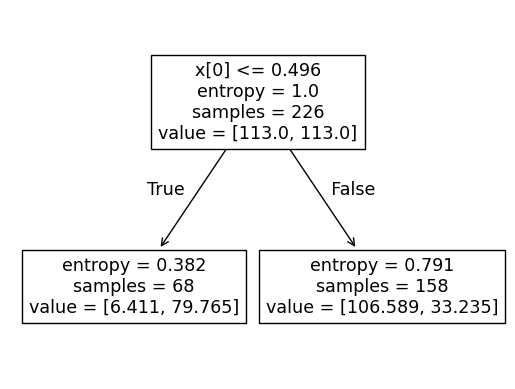

In [4]:
from tf_chpvk_pv.modeling.train import *
from tf_chpvk_pv.config import INTERIM_DATA_DIR
import pickle

t_sisso_expression = train_tree_sis_features_Ch()
train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression)

tfs = ['t_sisso', 't', 'tau', 't_jess']
tf_tresh = [1, 2, 1, 2]

df_acc =pd.DataFrame()
clfs = {}

for tf, tresh in zip(tfs, tf_tresh):
    df_acc, clf_t = test_tolerance_factor_Ch(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=tresh)
    clfs[tf] = clf_t

path_dict = INTERIM_DATA_DIR / "tolerance_factors.pkl"

with open(path_dict, 'wb') as file:
    pickle.dump(tolerance_factor_dict, file)

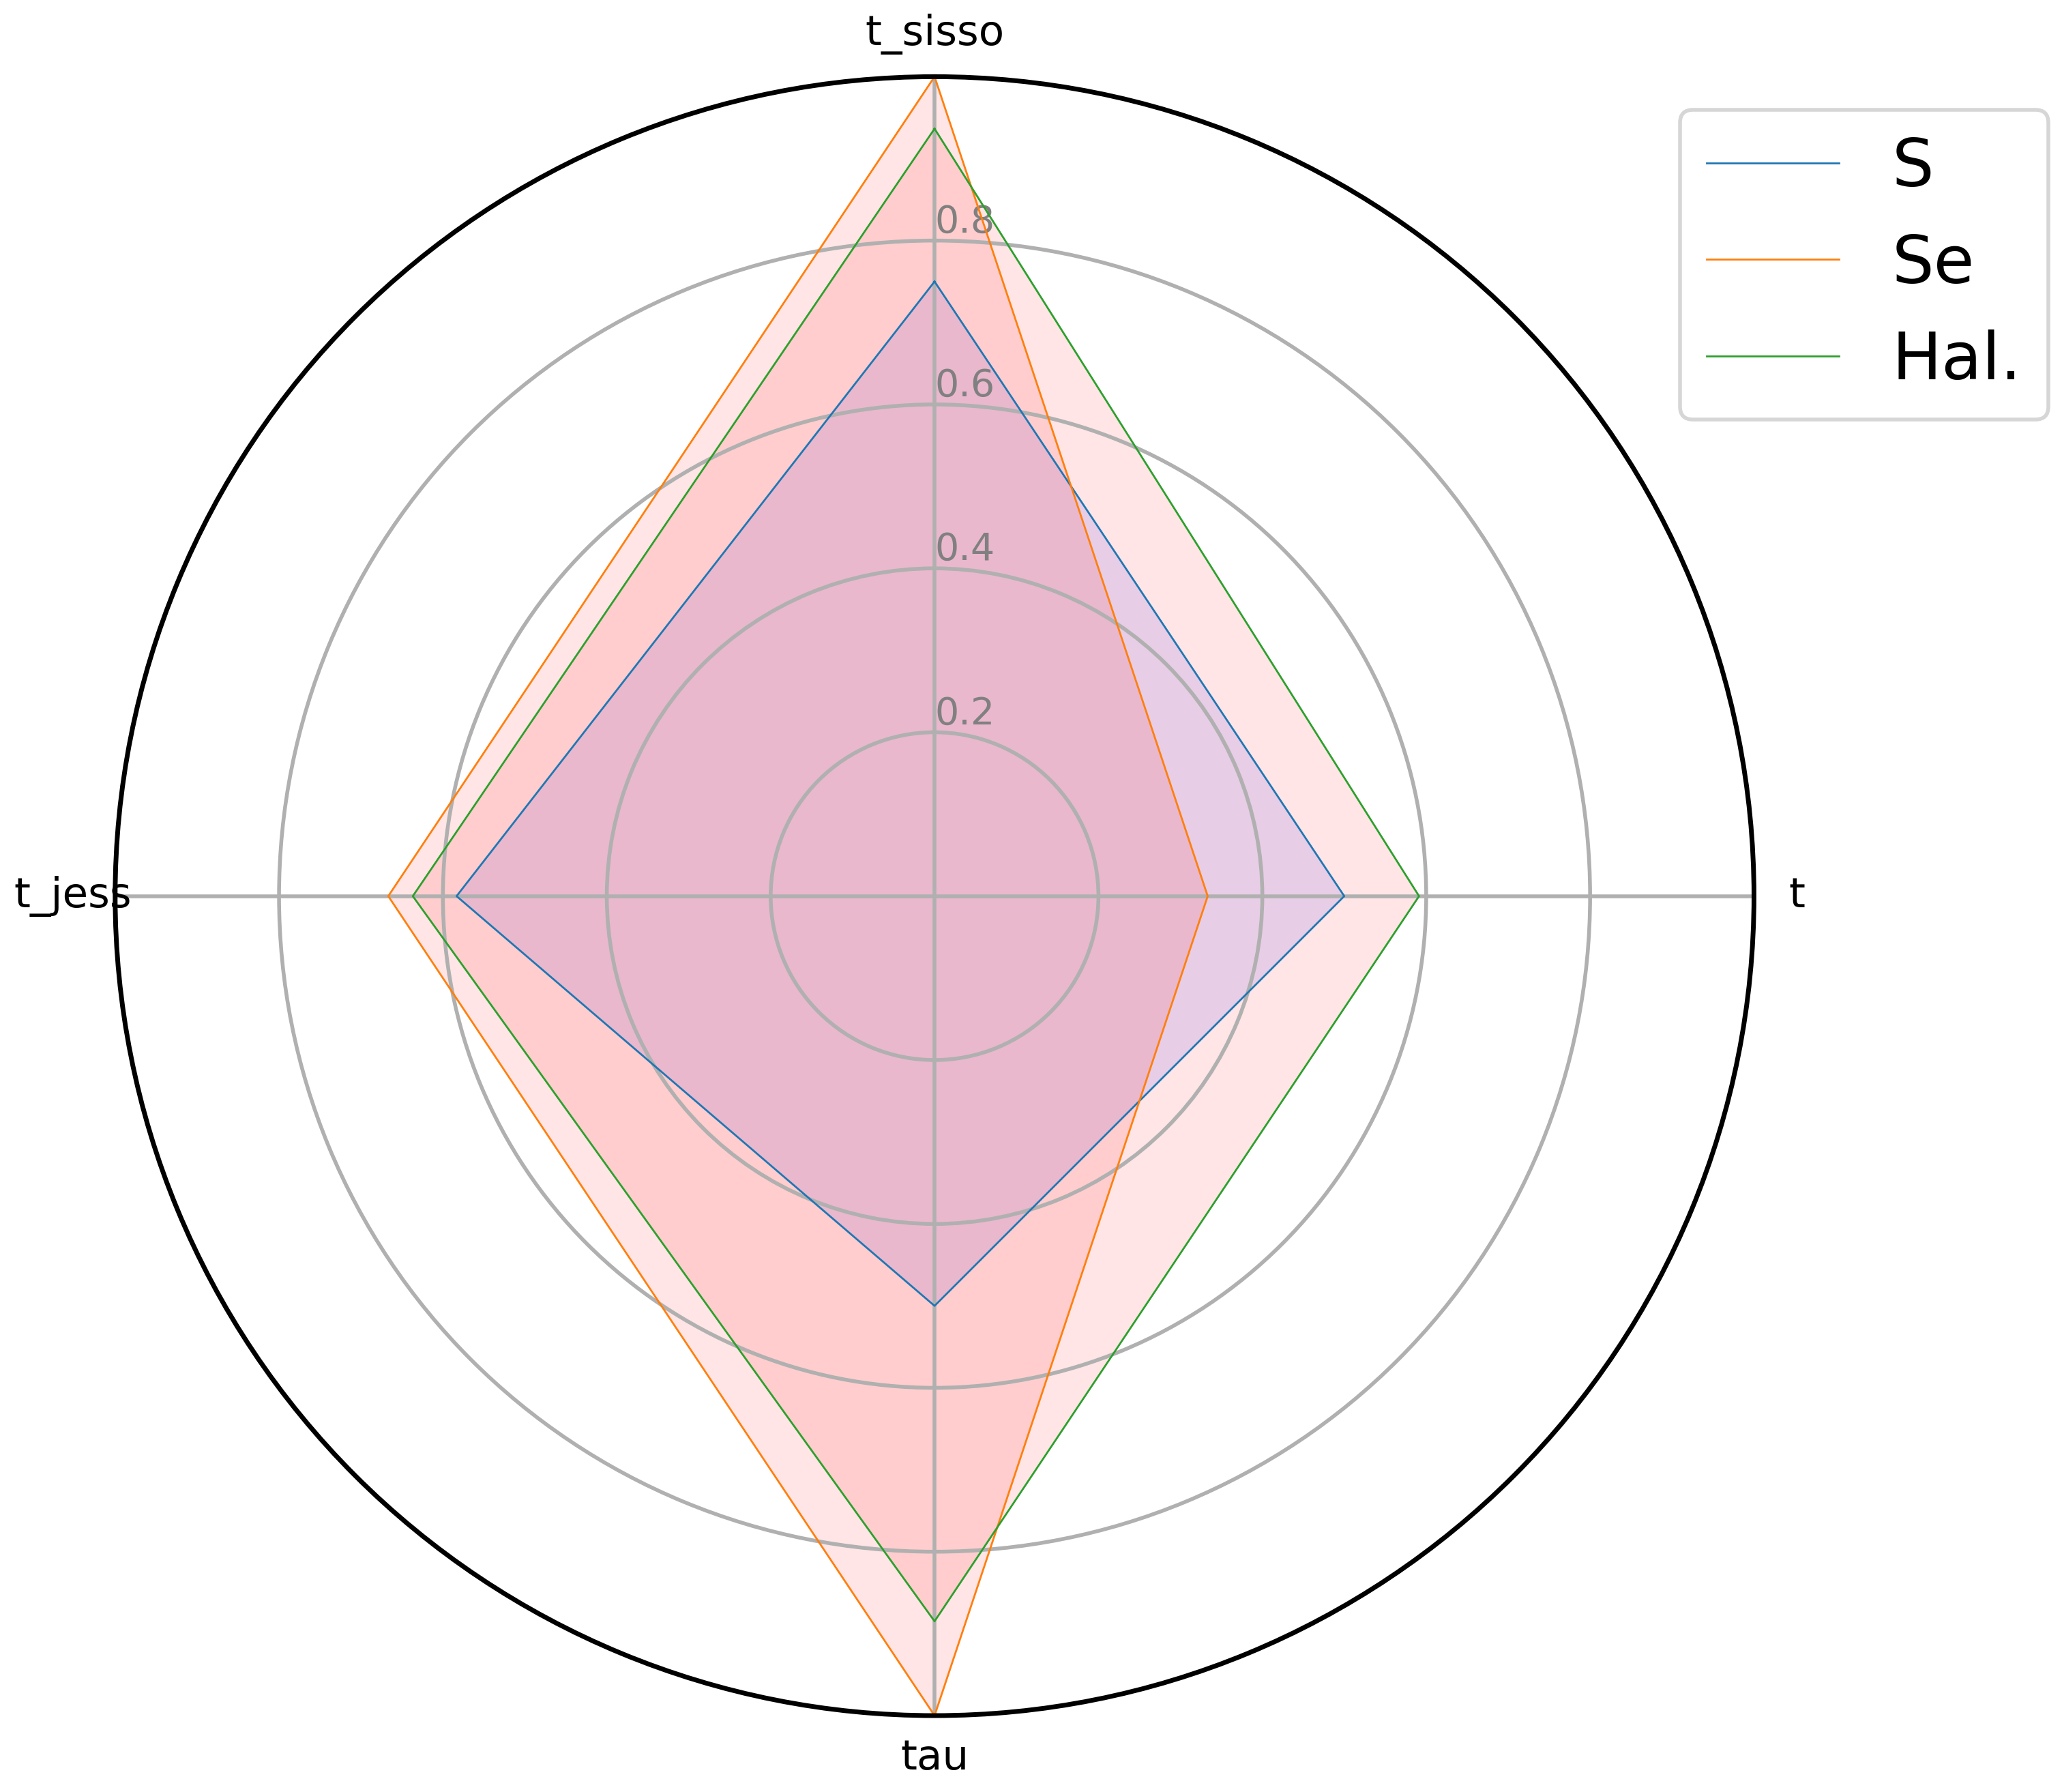

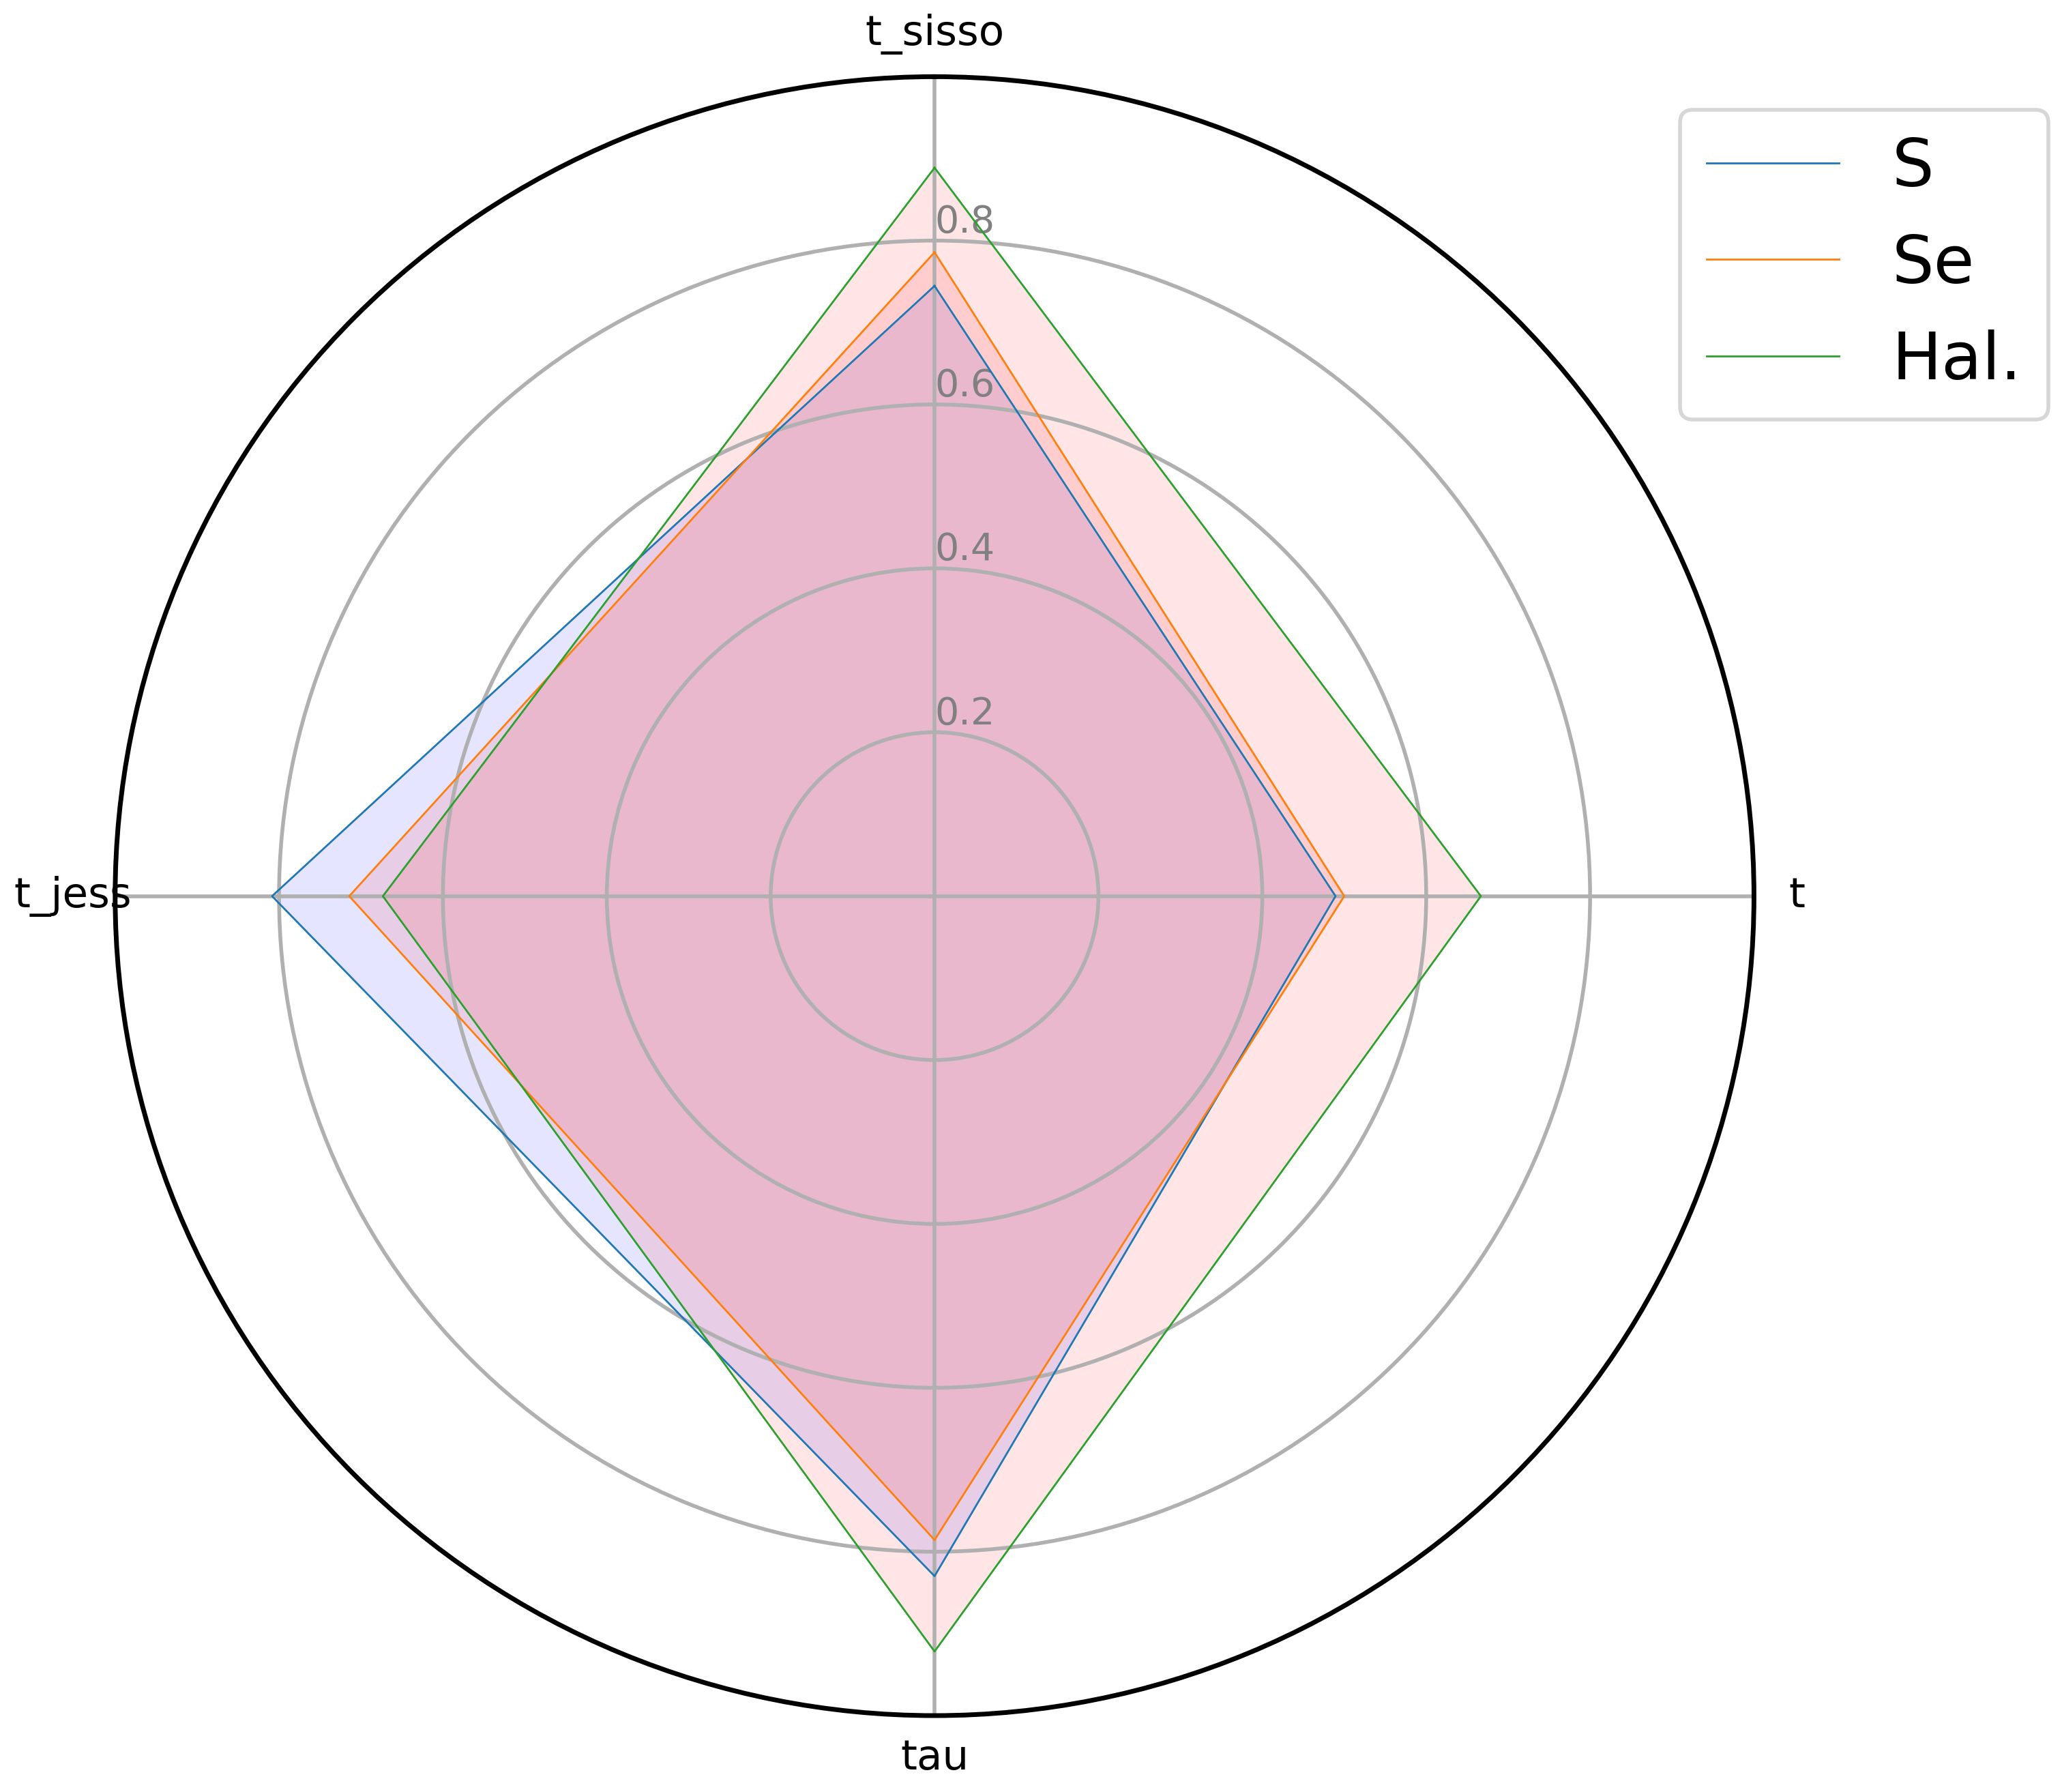

In [9]:
from tf_chpvk_pv.plots import spider_plot
import seaborn as sns

sns.set_context('poster')

test_idx = [x for x in df_acc.index if 'test' in x]
train_idx = [x for x in df_acc.index if 'train' in x]
test_acc = df_acc.loc[test_idx]
train_acc = df_acc.loc[train_idx]

test_acc.index = ['test_data', 'S', 'I', 'Cl','Br', 'F', 'Se']
train_acc.index = ['test_data', 'S', 'I', 'Cl','Br', 'F', 'Se']

#find mean for halides
test_hal = test_acc.loc[['I', 'Cl', 'Br', 'F']].mean(axis=0)
train_hal = train_acc.loc[['I', 'Cl', 'Br', 'F']].mean(axis=0)

test_acc['group'] = ['test_data', 'S', 'I', 'Cl','Br', 'F', 'Se']
train_acc['group'] = ['test_data', 'S', 'I', 'Cl','Br', 'F', 'Se']

test_acc.loc['hal'] = test_hal
test_acc.loc['hal', 'group'] = 'Hal.'

train_acc.loc['hal'] = train_hal
train_acc.loc['hal', 'group'] = 'Hal.'

spider_plot(test_acc, 'test data')
spider_plot(train_acc, 'train data')

2025-04-01 11:37:27.381 | INFO     | tf_chpvk_pv.modeling.train:train_platt_scaling:49 - Training Platt scaling model...
2025-04-01 11:37:27.416 | SUCCESS  | tf_chpvk_pv.modeling.train:train_platt_scaling:65 - Platt scaling model training complete.
2025-04-01 11:37:27.425 | INFO     | tf_chpvk_pv.plots:platt_scaling_plot:51 - Generating Platt Scaling plot from data...
2025-04-01 11:37:27.777 | SUCCESS  | tf_chpvk_pv.plots:platt_scaling_plot:63 - Plot generation complete.


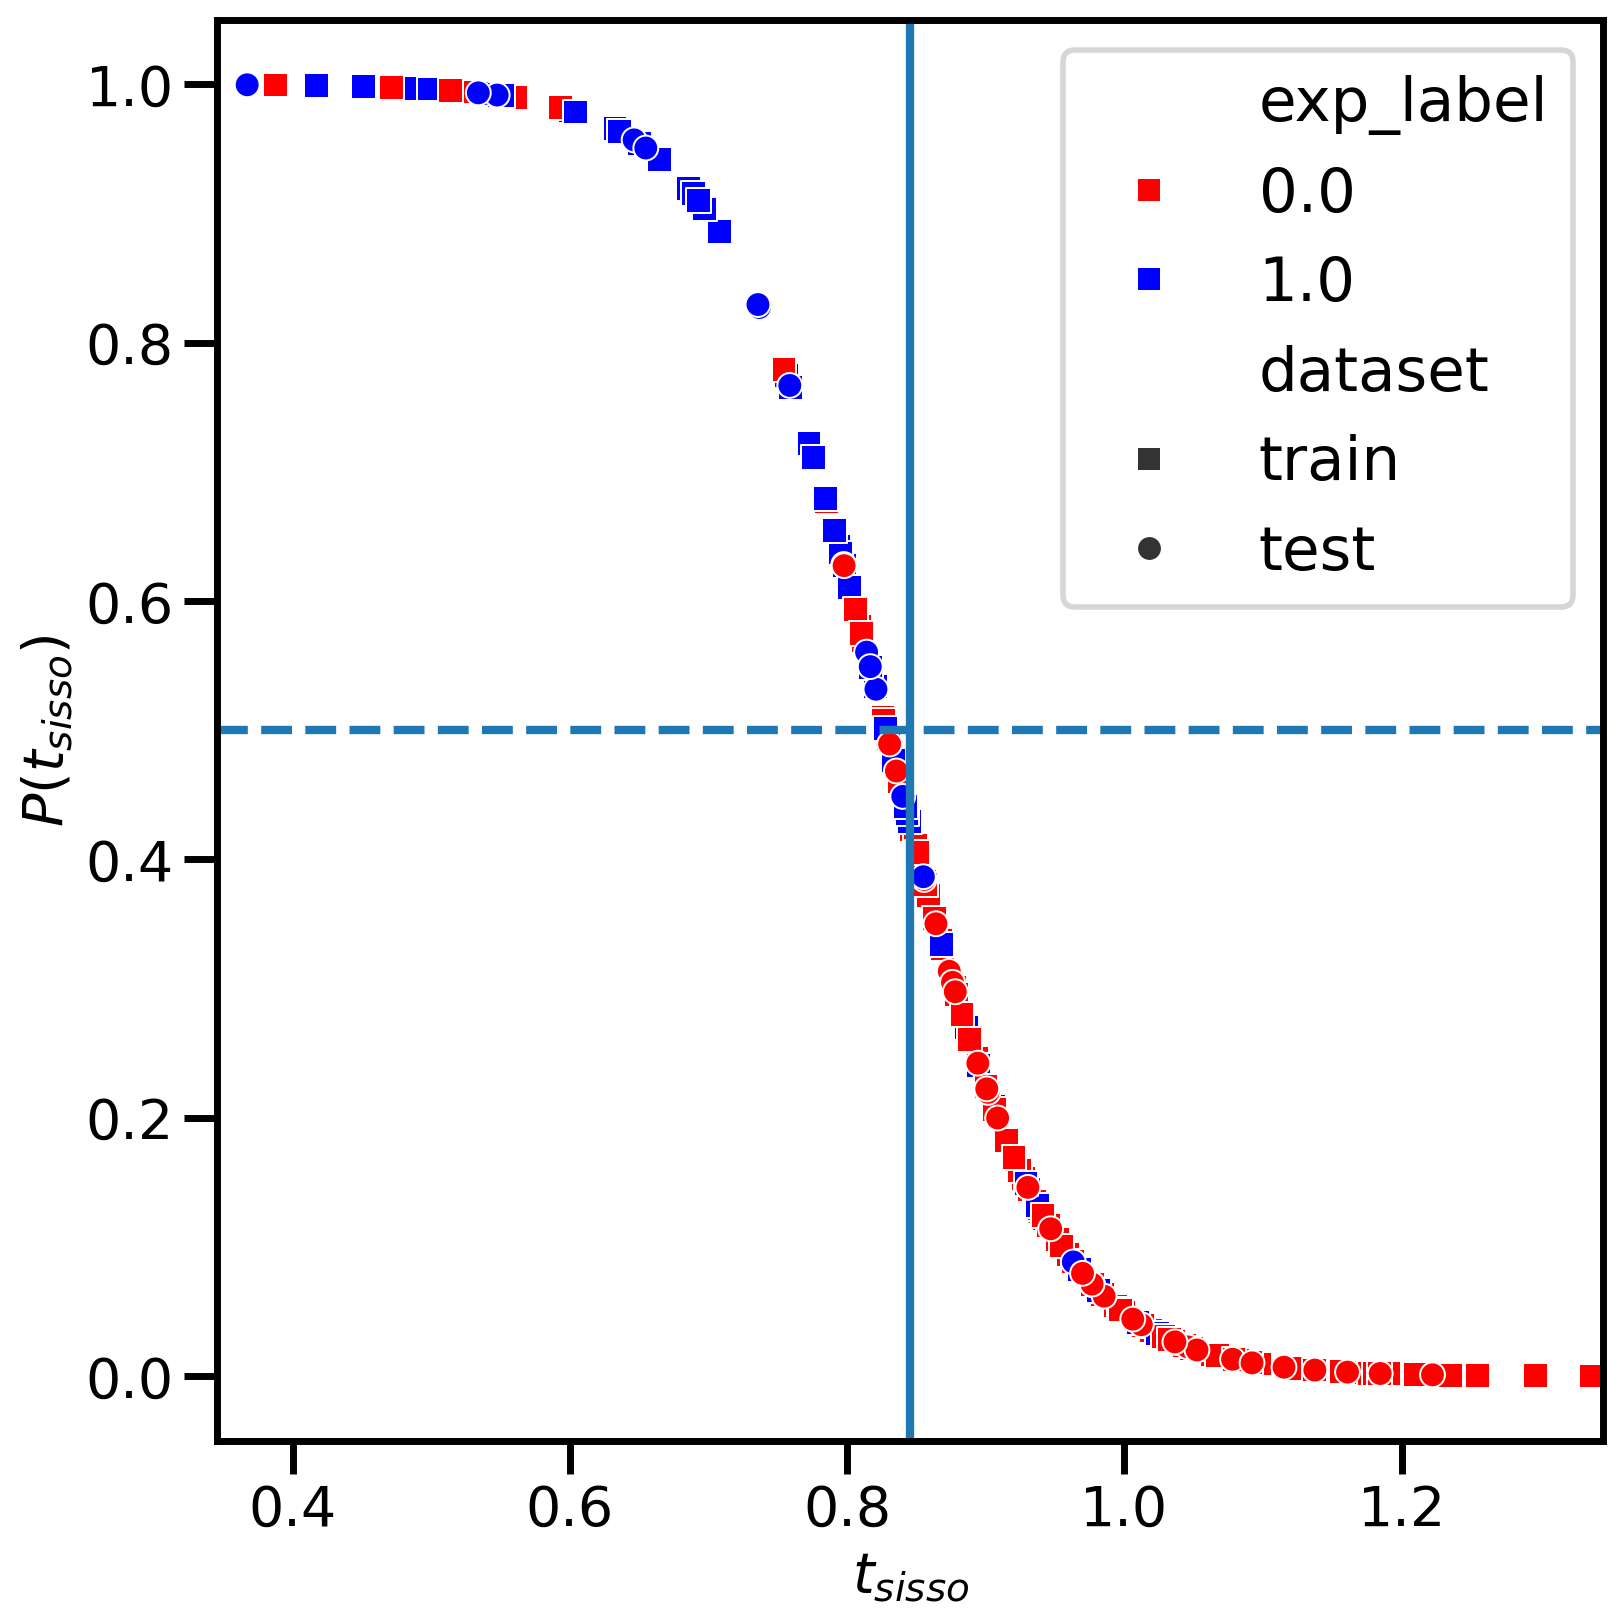

In [10]:
from tf_chpvk_pv.plots import platt_scaling_plot
import seaborn as sns

sns.set_context('poster')

train_df, test_df, cl2_tsisso = train_platt_scaling(train_df, test_df, clfs['t_sisso'])
platt_scaling_plot('t_sisso')

Now let's create new possible compositions

In [2]:
from tf_chpvk_pv.dataset import generate_compositions
from tf_chpvk_pv.modeling.predict import check_stable_compositions

element_selection_A = ["Ba", "Eu", "Pb", "Sr", "Ca", "Sn", "Cd", "Cu", "Mg",
                      "Zn", "Ge", "La", "Pr", "Ce", "Nd", "Yb", "Gd", "Sm", "Y",
                      "Dy", "Ho", "Er", "Tm", "Lu", "Sc", "Tl", "Bi"]

elements_selection_B = ["Si", "Ge", "V", "Rh", "Ti", "Ru", "Mo", "Ta", "Nb", "Hf",
                        "Zr", "Tb", "Pt", "Ce", "U", "Pd", "Ni", "Co", "Ga", "Al",
                        "Fe", "Cr", "In", "Mn", "Sc", "Lu", "Tm", "Er", "Ho", "Y",
                        "Yb"]

elements_selection = element_selection_A + elements_selection_B

possible_oxidation_states = [2.0, 3.0, 4.0] #3, 4] #for A and B elements

df_generated_comp = generate_compositions(elements_selection).dropna()

2025-04-01 11:35:45.231 | INFO     | tf_chpvk_pv.dataset:generate_compositions:247 - Generating valid compositions...
Invalid composition: CuBiS3
Invalid composition: CuBiSe3
Invalid composition: VCuS3
Invalid composition: VCuSe3
Invalid composition: CuRuS3
Invalid composition: CuRuSe3
Invalid composition: CuMoS3
Invalid composition: CuMoSe3
Invalid composition: TaCuS3
Invalid composition: TaCuSe3
Invalid composition: NbCuS3
Invalid composition: NbCuSe3
Invalid composition: CuPtS3
Invalid composition: CuPtSe3
Invalid composition: CrCuS3
Invalid composition: CrCuSe3
Invalid composition: TlVS3
Invalid composition: TlVSe3
Invalid composition: TlRuS3
Invalid composition: TlRuSe3
Invalid composition: TlMoS3
Invalid composition: TlMoSe3
Invalid composition: TaTlS3
Invalid composition: TaTlSe3
Invalid composition: NbTlS3
Invalid composition: NbTlSe3
Invalid composition: TlPtS3
Invalid composition: TlPtSe3
Invalid composition: UTlS3
Invalid composition: UTlSe3
Invalid composition: TlCrS3
Inval

According to t_sisso, 123 (10.585197934595525%) compositions are predicted to be stable as perovskites:
['BaCeS3', 'BaUS3', 'EuUS3', 'EuUSe3', 'EuInS3', 'EuInSe3', 'PbPrS3', 'PbCeS3', 'PbUS3', 'SrPrS3', 'SrCeS3', 'SrUS3', 'SrUSe3', 'CaPrS3', 'CaPrSe3', 'CaCeSe3', 'SnTbS3', 'SnTbSe3', 'CdPrS3', 'CdPrSe3', 'CdCeSe3', 'CuScSe3', 'CuTbS3', 'CuTbSe3', 'CuFeS3', 'CuFeSe3', 'MgVS3', 'MgVSe3', 'MgRhS3', 'MgRhSe3', 'MgTiS3', 'MgTiSe3', 'MgRuS3', 'MgRuSe3', 'MgMoS3', 'MgMoSe3', 'MgTaS3', 'MgTaSe3', 'MgNbS3', 'MgNbSe3', 'MgPtS3', 'MgPtSe3', 'MgPdS3', 'MgPdSe3', 'MgCrSe3', 'ZnVS3', 'ZnVSe3', 'ZnRhS3', 'ZnRhSe3', 'ZnTiS3', 'ZnTiSe3', 'ZnRuS3', 'ZnRuSe3', 'ZnMoS3', 'ZnMoSe3', 'ZnTaS3', 'ZnTaSe3', 'ZnNbS3', 'ZnNbSe3', 'ZnHfSe3', 'ZnPtS3', 'ZnPtSe3', 'ZnPdS3', 'ZnPdSe3', 'LaYbS3', 'LaYbSe3', 'LaErSe3', 'LaTmSe3', 'LaLuS3', 'LaLuSe3', 'LaTlSe3', 'PrYbSe3', 'PrLuSe3', 'CeYbSe3', 'CeTmSe3', 'CeLuS3', 'CeLuSe3', 'NdLuSe3', 'NdInS3', 'BiYbS3', 'BiYbSe3', 'GdInS3', 'GdInSe3', 'SmInS3', 'SmInSe3', 'BiYSe3', 

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:239: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


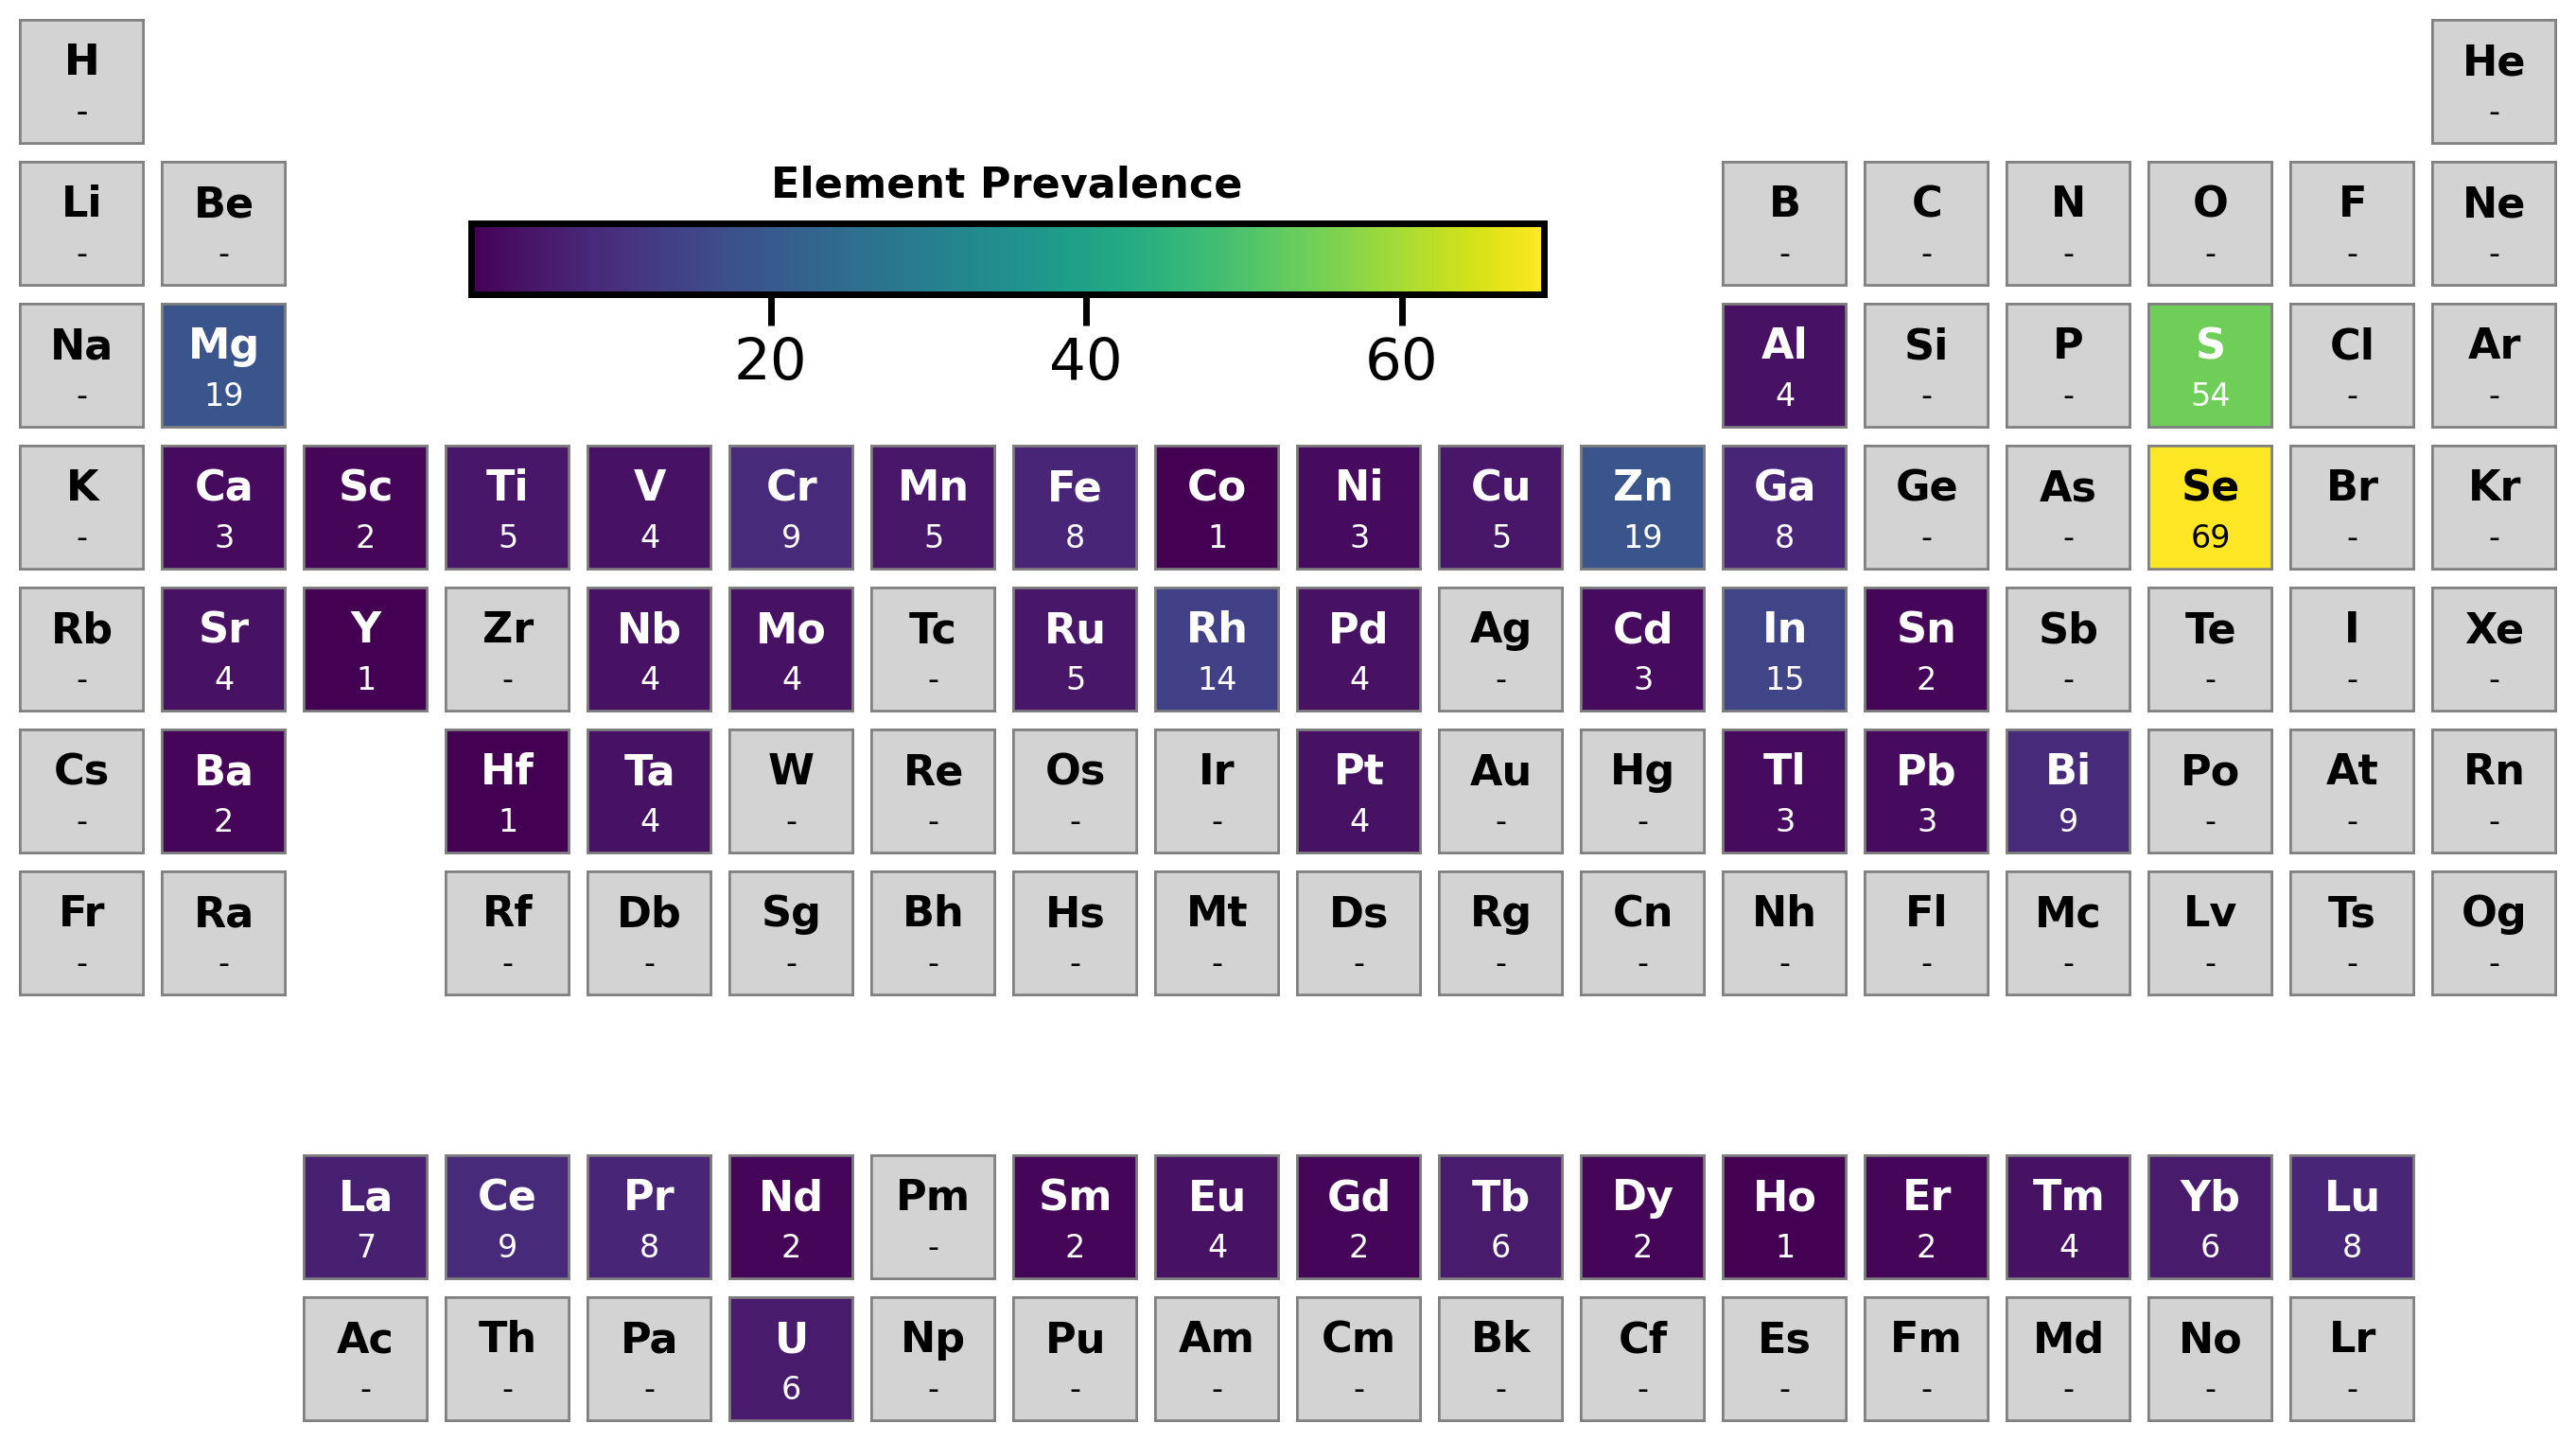

In [3]:
from tf_chpvk_pv.plots import graph_periodic_table
import seaborn as sns

sns.set_context('poster')

stable_candidates_t_sisso, df_out = check_stable_compositions('t_sisso')

graph_periodic_table(stable_candidates_t_sisso)

According to t_sisso, 385 (32.29865771812081%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPrS3', 'BaCeS3', 'BaHfS3', 'BaZrS3', 'BaTbS3', 'BaUS3', 'EuCuS3', 'EuCuSe3', 'EuScS3', 'EuScSe3', 'EuRhS3', 'EuRhSe3', 'EuMoS3', 'EuMoSe3', 'EuNiS3', 'EuNiSe3', 'EuCoS3', 'EuCoSe3', 'EuGaS3', 'EuGaSe3', 'EuAlS3', 'EuAlSe3', 'EuFeS3', 'EuFeSe3', 'EuCrS3', 'EuCrSe3', 'EuInS3', 'EuMnS3', 'EuMnSe3', 'CuLaS3', 'CuLaSe3', 'CuGaS3', 'CuAlS3', 'CuAlSe3', 'MgUS3', 'MgUSe3', 'LaYbS3', 'LaYbSe3', 'LaYS3', 'LaYSe3', 'LaHoS3', 'LaHoSe3', 'LaErS3', 'LaErSe3', 'LaTmS3', 'LaTmSe3', 'LaLuS3', 'LaLuSe3', 'LaScS3', 'LaScSe3', 'LaTlS3', 'LaTlSe3', 'LaVS3', 'LaVSe3', 'LaRhS3', 'LaRhSe3', 'LaTiS3', 'LaTiSe3', 'LaRuS3', 'LaRuSe3', 'LaMoS3', 'LaMoSe3', 'LaTaS3', 'LaTaSe3', 'LaNbS3', 'LaNbSe3', 'LaHfS3', 'LaNiS3', 'LaNiSe3', 'LaCoS3', 'LaCoSe3', 'LaGaS3', 'LaGaSe3', 'LaAlS3', 'LaAlSe3', 'LaFeS3', 'LaFeSe3', 'LaCrS3', 'LaCrSe3', 'LaInS3', 'LaInSe3', 'LaMnS3', 'LaMnSe3', 'PrLuS3', 'PrScS3', 'PrScS

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


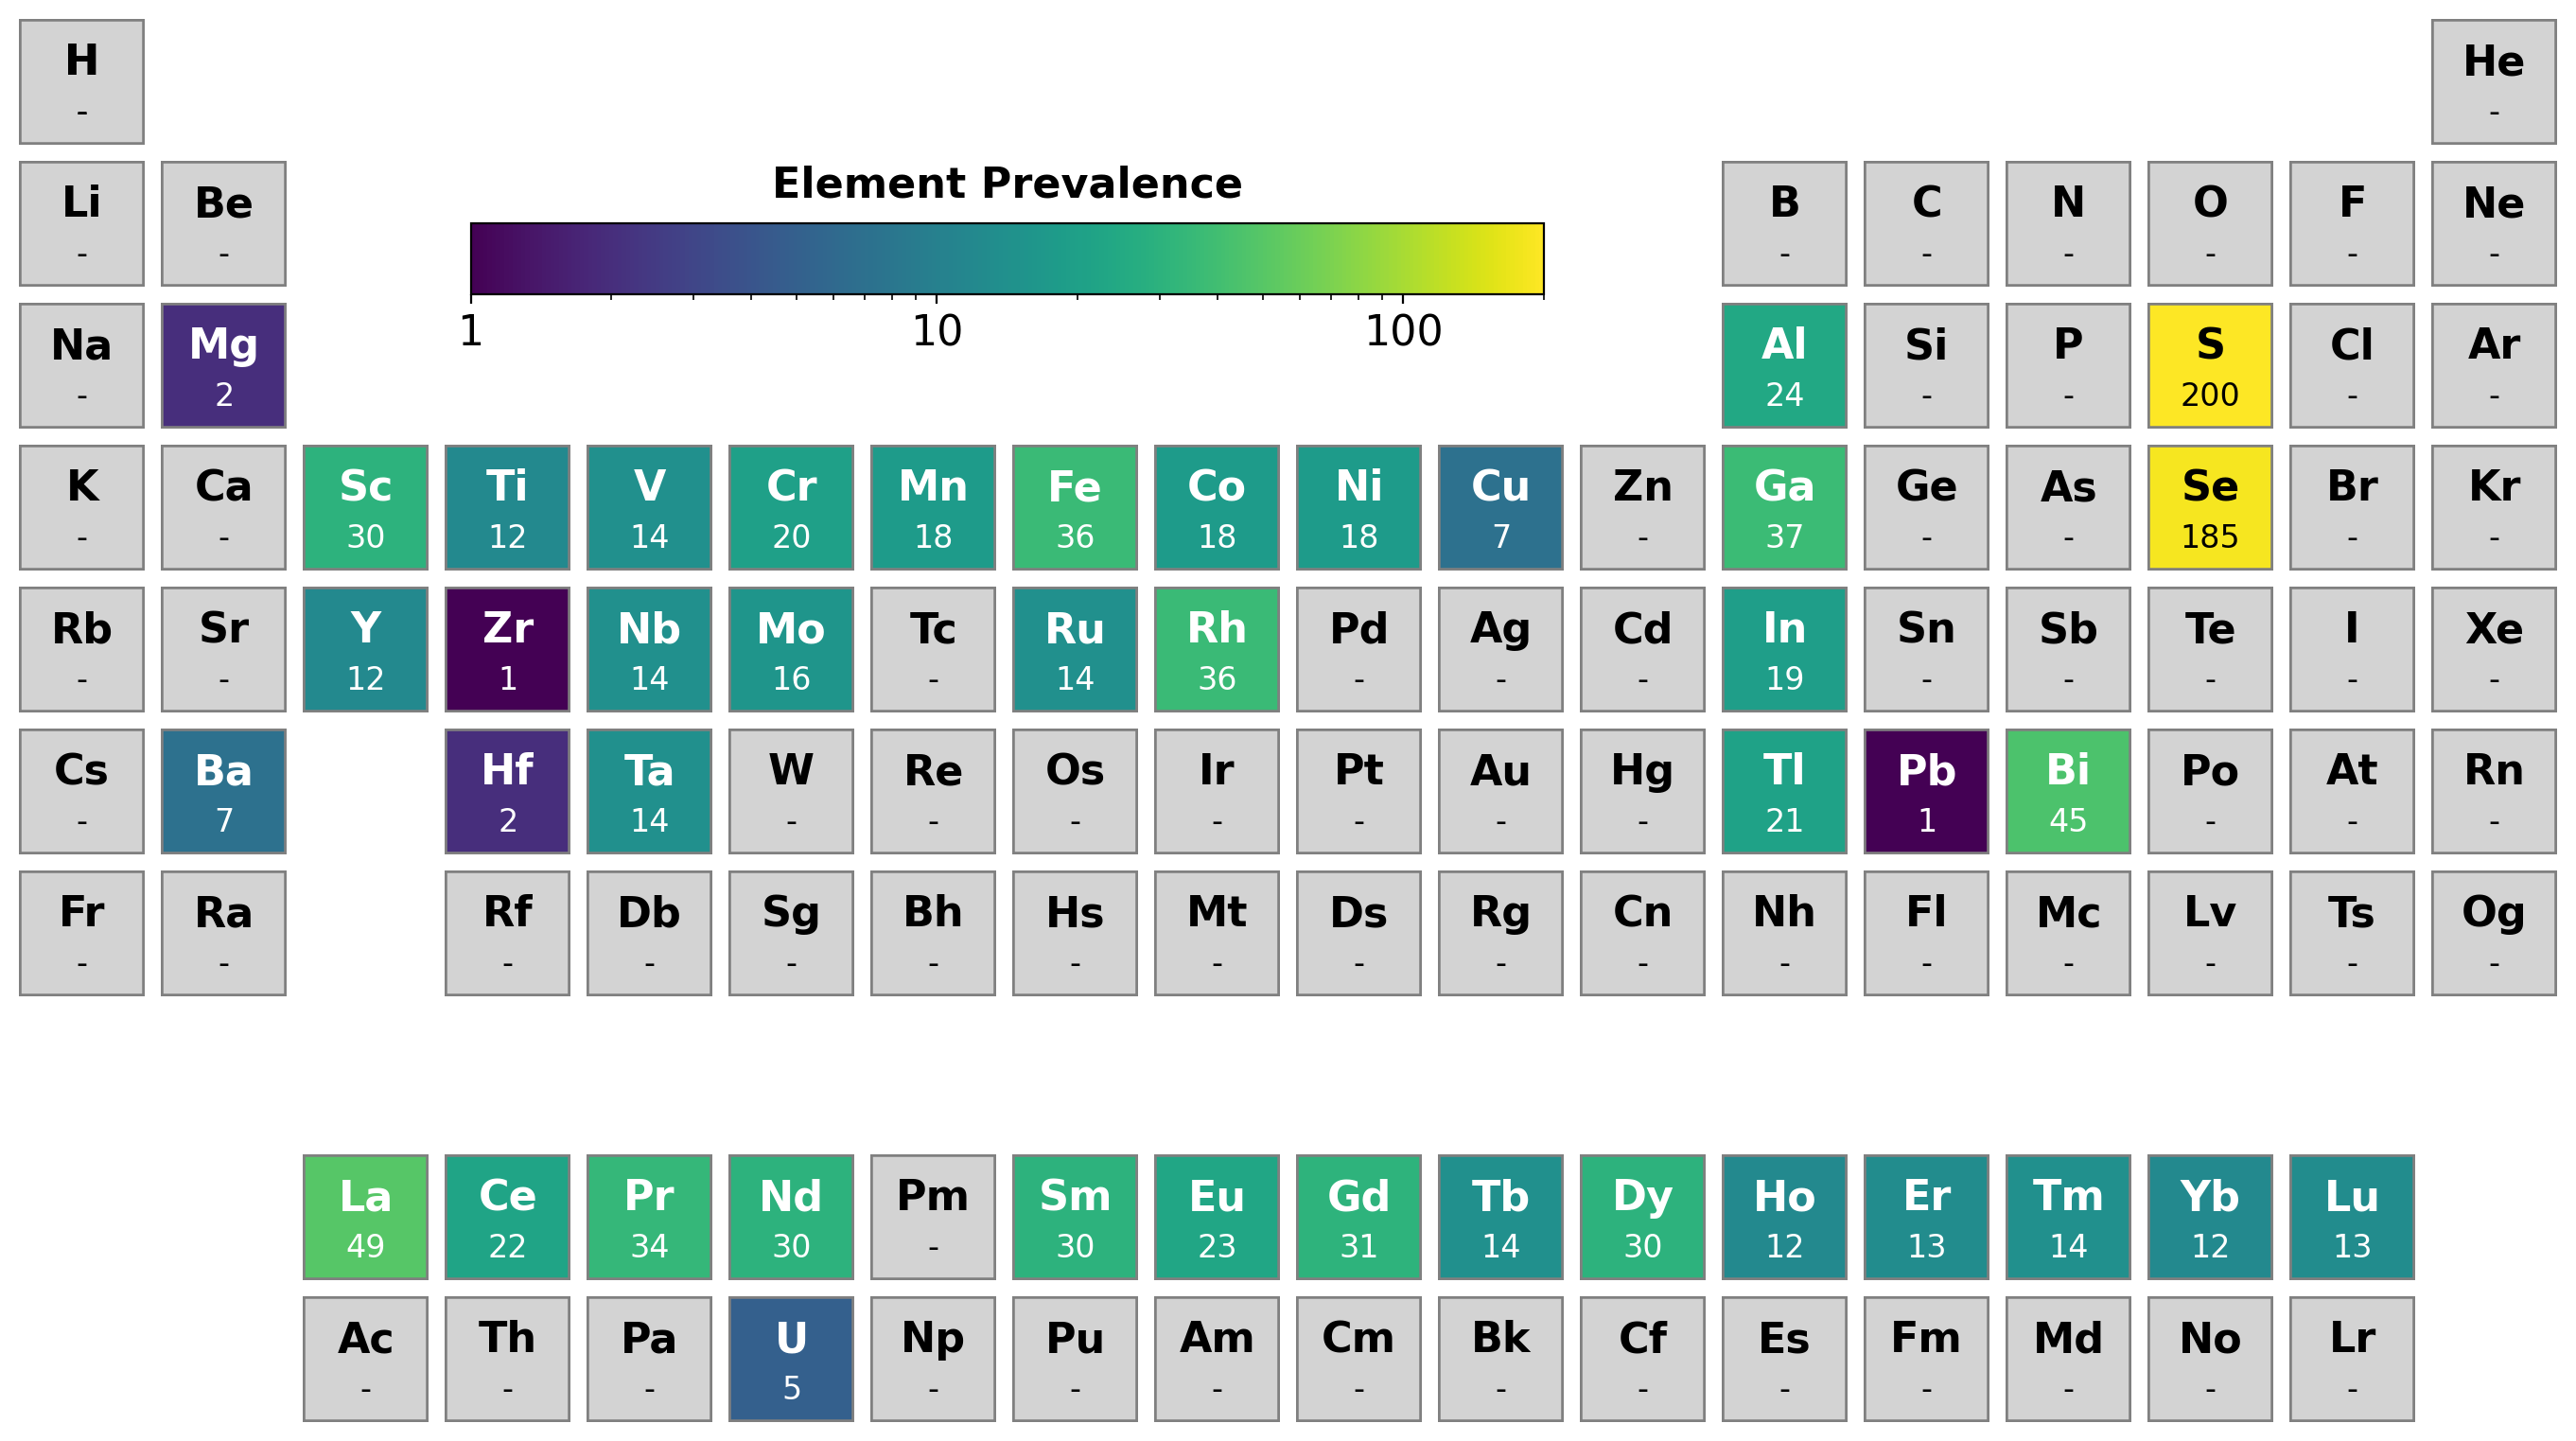

In [10]:
stable_candidates_tau, df_out = check_stable_compositions('tau')

graph_periodic_table(stable_candidates_tau, 'tau')